# Clustering on generated data

In [1]:
import os
import sys

sys.path.append("../")

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from src.ml.sinkhorn import SinkhornValue, sinkhorn

In [3]:
sns.set(style="whitegrid")

## Dataset generation

In [4]:
n_features = 512
n_clusters = 10
batch_size = 256

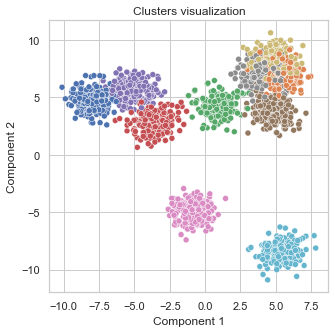

In [5]:
class BlobsDataset(Dataset):
    """
    https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
    """
    def __init__(self):
        X, y_true = make_blobs(
            n_samples=2000,
            n_features=n_features,
            centers=n_clusters,
            cluster_std=.8,
            random_state=0
        )
        
        self.X = torch.FloatTensor(X)
        self.y_true = torch.LongTensor(y_true)
    
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y_true[idx]
    
    def plot(self):
        fig, ax = plt.subplots(
            nrows=1,
            ncols=1,
            figsize=(5, 5)
        )

        sns.scatterplot(  # plot first 2 components
            x=self.X[:, 0],
            y=self.X[:, 1],
            hue=map(str, self.y_true),
            ax=ax,
            legend=False
        )

        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_title("Clusters visualization")

        return fig
    
blobs_dataset = BlobsDataset()
blobs_dataset.plot();

In [6]:
blobs_dataloader = DataLoader(
    blobs_dataset,
    shuffle=True,
    batch_size=batch_size
)

## Model definition

In [7]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )
    
    def forward(self, inputs):
        mlp_out = self.mlp(inputs)
        softmax_out = nn.LogSoftmax(dim=1)(mlp_out)
        
        return softmax_out

In [62]:
model = Model(
    input_dim=n_features,
    output_dim=n_clusters
)

torch.autograd.set_detect_anomaly(True)

optimizer = torch.optim.SGD(lr=0.05, params=model.parameters())

for epoch in range(50):
    epoch_loss = 0

    for batch_ix, (inputs, y_true) in enumerate(blobs_dataloader):
        a = torch.ones(inputs.shape[0]) / inputs.shape[0]  # batch size
        b = torch.ones(n_clusters) / n_clusters            # number of clusters
        
        model.train()

        P = model(inputs)
        M = P - np.log(inputs.shape[0])

        # set gradients to zero
        optimizer.zero_grad()

        # init Sinkhorn loss
        SV = SinkhornValue(
           a,
           b,
           epsilon=0.1,
           solver=sinkhorn,
           n_iter=10
        )
        
        with torch.no_grad():
            Q = sinkhorn(M, a, b, epsilon=0.1, n_iter=10)

        # compute Sinkhorn loss
        loss = -SV(M)

        # compute gradients
        loss.backward()

        # backpropagation
        optimizer.step()

        epoch_loss += loss.item()
        
    print("Epoch {0} loss: {1:.4f}".format(epoch+1, epoch_loss / (batch_ix+1)))

Epoch 1 loss: 5.2979
Epoch 2 loss: 4.8893
Epoch 3 loss: 4.8785
Epoch 4 loss: 4.8757
Epoch 5 loss: 4.8741
Epoch 6 loss: 4.8722
Epoch 7 loss: 4.8723
Epoch 8 loss: 4.8715
Epoch 9 loss: 4.8711
Epoch 10 loss: 4.8709
Epoch 11 loss: 4.8703
Epoch 12 loss: 4.8703
Epoch 13 loss: 4.8703
Epoch 14 loss: 4.8704
Epoch 15 loss: 4.8701
Epoch 16 loss: 4.8702
Epoch 17 loss: 4.8699
Epoch 18 loss: 4.8697
Epoch 19 loss: 4.8702
Epoch 20 loss: 4.8701
Epoch 21 loss: 4.8695
Epoch 22 loss: 4.8693
Epoch 23 loss: 4.8696
Epoch 24 loss: 4.8694
Epoch 25 loss: 4.8693
Epoch 26 loss: 4.8694
Epoch 27 loss: 4.8698
Epoch 28 loss: 4.8694
Epoch 29 loss: 4.8699
Epoch 30 loss: 4.8691
Epoch 31 loss: 4.8696
Epoch 32 loss: 4.8695
Epoch 33 loss: 4.8696
Epoch 34 loss: 4.8697
Epoch 35 loss: 4.8696
Epoch 36 loss: 4.8693
Epoch 37 loss: 4.8694
Epoch 38 loss: 4.8693
Epoch 39 loss: 4.8690
Epoch 40 loss: 4.8691
Epoch 41 loss: 4.8690
Epoch 42 loss: 4.8701
Epoch 43 loss: 4.8693
Epoch 44 loss: 4.8700
Epoch 45 loss: 4.8692
Epoch 46 loss: 4.86

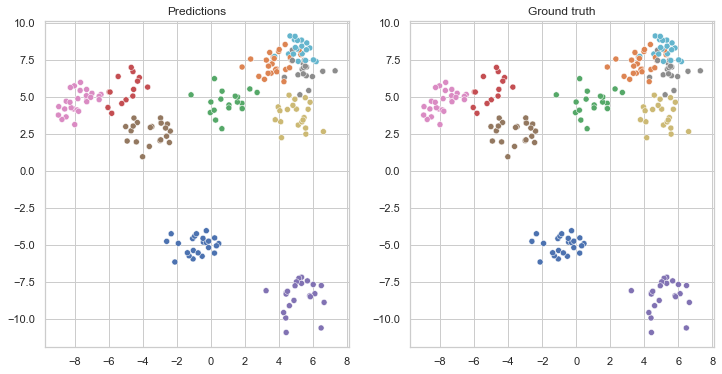

In [63]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.scatterplot(
    x=inputs[:, 0],
    y=inputs[:, 1],
    hue=map(str, torch.argmax(Q, axis=1)),
    legend=False,
    ax=axs[0]
)

sns.scatterplot(
    x=inputs[:, 0],
    y=inputs[:, 1],
    hue=map(str, y_true),
    legend=False,
    ax=axs[1]
)

axs[0].set_title("Predictions")
axs[1].set_title("Ground truth")

plt.show()